# Legacy vs Updated Electromagnetic Simulation Comparison

This notebook compares the legacy and updated integrator results on the same plots, reproducing the first two energy plots from the original two_particle_main demo.

In [39]:
# Import Required Libraries and Modules
import numpy as np
import matplotlib.pyplot as plt
import time

# Import core electromagnetic simulation modules
from core.performance import OptimizedLienardWiechertIntegrator, LienardWiechertIntegrator
from core.particle_initialization import initialize_particle_bunches
from legacy.plotting_variables import calculate_plotting_variables

# Import legacy modules for comparison
import sys
sys.path.append('legacy')
from covariant_integrator_library import retarded_integrator3
from bunch_inits import init_bunch

# Set professional plotting style
plt.rcParams.update({'font.size': 14})
print("✅ All modules loaded successfully")

✅ All modules loaded successfully


In [40]:
# Reload modules to get latest changes
import importlib
importlib.reload(__import__('core.particle_initialization'))
from core.particle_initialization import initialize_particle_bunches

In [41]:
# Initialize Particle Bunch Parameters (matching original demo exactly)

# Physical constants
c_ms = 299792458
transv_dist = 2e-1

# Particle specifications (CORRECTED parameter names to match legacy)
rider_params = {
    'particle_mass_amu': 1.007319468,  # proton
    'stripped_ions': 1.0,
    'charge_sign': 1.0,
    'starting_pz': 1.01e6,
    'transv_momentum': 0.0,
    'starting_distance': 1e-6,
    'transv_distance': transv_dist,  # CORRECT key name
	'transv_offset' : 0 ,
    'particle_count': 10}

driver_params = {
    'particle_mass_amu': 207.2,  # lead
    'stripped_ions': 54.0,
    'charge_sign': -1.0,
    'starting_pz': -rider_params['starting_pz'] / 207.2 * rider_params['particle_mass_amu'],
    'transv_momentum': 0.0,
    'starting_distance': 70.0,
    'transv_distance': -transv_dist,  # CORRECT key name
    'transv_offset': 2e-1,  # offset between rider/driver
    'particle_count': 10
}

# Integration parameters (reduced step sizes for realistic travel distances)
integration_params = {
    'static_steps': 1,
    'ret_steps': 25,
    'step_size': 1e-6,  # Reduced from 2e-6
    'static_steps2': 1,
    'ret_steps2': 750,
    'step_size2': 1e-7,  # Reduced from 3e-6
    'sim_type': 2,
    'bunch_dist': 1e5,
    'cav_spacing': 1e5,
    'aperture': 1e5,
    'z_cutoff': 0,
    'wall_pos': 1e5
}

print("✅ Parameters initialized successfully")
print(f"Rider: {rider_params['particle_mass_amu']} amu, charge = {rider_params['charge_sign'] * rider_params['stripped_ions']}")
print(f"Driver: {driver_params['particle_mass_amu']} amu, charge = {driver_params['charge_sign'] * driver_params['stripped_ions']}")
print(f"Expected rider momentum: {rider_params['starting_pz']:.2e}")
print(f"Expected driver momentum: {driver_params['starting_pz']:.2e}")

✅ Parameters initialized successfully
Rider: 1.007319468 amu, charge = 1.0
Driver: 207.2 amu, charge = -54.0
Expected rider momentum: 1.01e+06
Expected driver momentum: -4.91e+03


In [42]:
# Create and Configure Particle Bunches 

# Create particle states directly (matching legacy bunch_inits.py exactly)
def create_verified_particle_state(params):
    """Create particle state using exact legacy bunch_inits.py physics."""
    count = params['particle_count']
    c_mmns = 299.792458  # mm/ns (exact legacy constant)
    
    # Calculate mass and charge (exact legacy method)
    macro_pop = 1
    mass = params['particle_mass_amu'] * macro_pop
    q = params['charge_sign'] * 1.178734E-5 * params['stripped_ions'] * macro_pop
    char_time = 2/3 * q**2 / (mass * c_mmns**3)
    
    # Momentum components (exact legacy method)
    Px = np.random.uniform(-params['transv_momentum'], params['transv_momentum'] ,count)*mass
    Py = np.random.uniform(-params['transv_momentum'], params['transv_momentum'] ,count)*mass
    Pz = np.random.uniform(params['starting_pz'], params['starting_pz']+0.1, count)*mass #  6.3E2 is 2 GeV for protons
    
    # Calculate total momentum and gamma (CRITICAL - exact legacy physics)
    Pt = np.sqrt(Px**2 + Py**2 + Pz**2 + mass**2 * c_mmns**2)
    gamma = Pt / (mass * c_mmns)  # CORRECT gamma calculation
    
    # Calculate velocities (exact legacy method)
    bx = Px / (gamma * mass * c_mmns)
    by = Py / (gamma * mass * c_mmns)
    bz = Pz / (gamma * mass * c_mmns)
    
    # Position initialization
    x = np.random.uniform(-params['transv_distance']+params['transv_offset'],params['transv_distance']+ params['transv_offset'],count)
    y = np.random.uniform(-params['transv_distance']+params['transv_offset'],params['transv_distance']+ params['transv_offset'],count)
    z = np.random.uniform(params['starting_distance']-1e-6, params['starting_distance']+1e-6, count)
    t = np.zeros(count)
    
    # Create state dictionary (exact legacy format)
    state = {
        'x': x, 'y': y, 'z': z, 't': t,
        'Px': Px, 'Py': Py, 'Pz': Pz, 'Pt': Pt,
        'gamma': gamma,  # CORRECT gamma values
        'bx': bx, 'by': by, 'bz': bz,
        'bdotx': np.zeros(count),
        'bdoty': np.zeros(count),
        'bdotz': np.zeros(count),
        'q': np.full(count, q),
        'm': np.full(count, mass),
        'char_time': np.full(count, char_time)
    }
    
    rest_energy = params['particle_mass_amu'] * 931.494  # MeV
    return state, rest_energy

# Create particle states using corrected physics
rider_state, rider_energy_mev = create_verified_particle_state(rider_params)
driver_state, driver_energy_mev = create_verified_particle_state(driver_params)
driver_state['x'] = np.full(driver_params['particle_count'], -transv_dist)  # Opposite side
driver_state['y'] = np.full(driver_params['particle_count'], -transv_dist)  # Opposite side

print(f"✅ Particle bunches initialized:")
print(f"   Rider rest energy: {rider_energy_mev:.2f} MeV")
print(f"   Rider gamma: {rider_state['gamma'][0]:.6f}")
print(f"   Driver rest energy: {driver_energy_mev:.2f} MeV") 
print(f"   Driver gamma: {driver_state['gamma'][0]:.6f}")

✅ Particle bunches initialized:
   Rider rest energy: 938.31 MeV
   Rider gamma: 3368.997643
   Driver rest energy: 193005.56 MeV
   Driver gamma: 16.409056


In [43]:
# Run the electromagnetic integrator (USE BASE CLASS to avoid optimization issues)
from core.trajectory_integrator import LienardWiechertIntegrator as BaseLW
integrator = BaseLW()  

# Run two-stage integration (matching original demo)
print("\n🔄 Running electromagnetic simulation...")
start_time = time.time()

# Stage 1: Coarse integration
rider_traj_1, driver_traj_1 = integrator.integrate_retarded_fields(
    integration_params['static_steps'], integration_params['ret_steps'], integration_params['step_size'],
    integration_params['wall_pos'], integration_params['aperture'], integration_params['sim_type'],
    rider_state, driver_state,
    integration_params['bunch_dist'], integration_params['z_cutoff'], integration_params['cav_spacing']
)

# Stage 2: Fine integration (interaction zone)
rider_trajectory, driver_trajectory = integrator.integrate_retarded_fields(
    integration_params['static_steps2'], integration_params['ret_steps2'], integration_params['step_size2'],
    integration_params['wall_pos'], integration_params['aperture'], integration_params['sim_type'],
    rider_traj_1[-1], driver_traj_1[-1],
    integration_params['bunch_dist'], integration_params['z_cutoff'], integration_params['cav_spacing']
)

integration_time = time.time() - start_time
print(f"✅ Integration completed in {integration_time:.2f} seconds")
print(f"   Final trajectory lengths: Rider={len(rider_trajectory)}, Driver={len(driver_trajectory)}")
print(f"   Final rider gamma: {rider_trajectory[-1]['gamma'][0]:.6f}")
print(f"   Final driver gamma: {driver_trajectory[-1]['gamma'][0]:.6f}")


🔄 Running electromagnetic simulation...
  Updated integrator: 26 steps (static: 1, retarded: 25)
  Simulation type: 2, wall_Z: 100000.0, apt_R: 100000.0


  Updated integrator: 751 steps (static: 1, retarded: 750)
  Simulation type: 2, wall_Z: 100000.0, apt_R: 100000.0
✅ Integration completed in 12.91 seconds
   Final trajectory lengths: Rider=751, Driver=751
   Final rider gamma: 3368.997633
   Final driver gamma: 16.409057


In [44]:
# Run Legacy Simulation for Comparison
print("🔄 Running legacy simulation...")
legacy_start_time = time.time()

# Initialize legacy particle states (matching original demo exactly)
init_rider_legacy, E_MeV_rest_rider = init_bunch(
    rider_params['starting_distance'], rider_params['transv_momentum'], rider_params['starting_pz'],
    rider_params['stripped_ions'], rider_params['particle_mass_amu'], transv_dist, 
    rider_params['particle_count'], rider_params['charge_sign']
)
init_driver_legacy, E_MeV_rest_driver = init_bunch(
    driver_params['starting_distance'], driver_params['transv_momentum'], driver_params['starting_pz'],
    driver_params['stripped_ions'], driver_params['particle_mass_amu'], -transv_dist,
    driver_params['particle_count'], driver_params['charge_sign']
)

# Run legacy two-stage integration
legacy_traj_1, legacy_drv_traj_1 = retarded_integrator3(
    integration_params['static_steps'], integration_params['ret_steps'], integration_params['step_size'],
    integration_params['wall_pos'], integration_params['aperture'], integration_params['sim_type'],
    init_rider_legacy, init_driver_legacy, integration_params['bunch_dist'], 
    integration_params['cav_spacing'], integration_params['z_cutoff']
)

legacy_rider_trajectory, legacy_driver_trajectory = retarded_integrator3(
    integration_params['static_steps2'], integration_params['ret_steps2'], integration_params['step_size2'],
    integration_params['wall_pos'], integration_params['aperture'], integration_params['sim_type'],
    legacy_traj_1[-1], legacy_drv_traj_1[-1], integration_params['bunch_dist'],
    integration_params['cav_spacing'], integration_params['z_cutoff']
)

legacy_time = time.time() - legacy_start_time
print(f"✅ Legacy integration completed in {legacy_time:.2f} seconds")
print(f"   Final trajectory lengths: Rider={len(legacy_rider_trajectory)}, Driver={len(legacy_driver_trajectory)}")
print(f"   Final rider gamma: {legacy_rider_trajectory[-1]['gamma'][0]:.6f}")
print(f"   Final driver gamma: {legacy_driver_trajectory[-1]['gamma'][0]:.6f}")

🔄 Running legacy simulation...
E_MeV =  3161420.067617779
Gamma =  3368.997811545018
E_rest =  938.385948501337
E_MeV =  -3161391.6965929186
Gamma =  16.40900558789942
E_rest =  193020.75925874696
✅ Legacy integration completed in 11.51 seconds
   Final trajectory lengths: Rider=751, Driver=751
   Final rider gamma: 3370.518928
   Final driver gamma: 16.408832
✅ Legacy integration completed in 11.51 seconds
   Final trajectory lengths: Rider=751, Driver=751
   Final rider gamma: 3370.518928
   Final driver gamma: 16.408832


In [45]:
# Calculate Legacy Plotting Variables (using proper legacy method)
print("🔄 Calculating legacy plotting variables...")
legacy_plot_vars = calculate_plotting_variables(
    legacy_rider_trajectory, legacy_driver_trajectory, 
    init_rider_legacy, init_driver_legacy,
    integration_params['static_steps2'], integration_params['ret_steps2'], 
    E_MeV_rest_rider, E_MeV_rest_driver, c_ms
)

# Unpack legacy variables for plotting
(delta_e_legacy, delta_e_drv_legacy, tot_e_legacy, tot_e_drv_legacy, 
 delta_e_keV_legacy, delta_e_MeV_legacy, tot_e_GeV_legacy, 
 delta_e_keV_drv_legacy, delta_e_MeV_drv_legacy, tot_e_GeV_drv_legacy,
 zs_legacy, xs_legacy, zs_drv_legacy, xs_drv_legacy, *_) = legacy_plot_vars

print(f"✅ Legacy plotting variables calculated: {len(zs_legacy)} rider points, {len(zs_drv_legacy)} driver points")


🔄 Calculating legacy plotting variables...
✅ Legacy plotting variables calculated: 748 rider points, 748 driver points


In [46]:
# Calculate Updated Plotting Variables (matching legacy method exactly)
def calculate_updated_plotting_variables(rider_traj, driver_traj, init_rider, init_driver, static_steps, ret_steps, E_MeV_rest_rider, E_MeV_rest_driver, c_ms):
    """Calculate plotting variables for updated integrator using exact legacy method."""
    tot_steps = static_steps + ret_steps
    
    # Calculate delta_e using gamma differences (exact legacy method)
    delta_e = [np.mean(rider_traj[i]['gamma'] - init_rider['gamma']) * E_MeV_rest_rider for i in range(2, tot_steps - 1)]
    delta_e_drv = [np.mean(driver_traj[i]['gamma'] - init_driver['gamma']) * E_MeV_rest_driver for i in range(2, tot_steps - 1)]
    
    # Total energies
    tot_e = [np.mean(rider_traj[i]['gamma']) * E_MeV_rest_rider for i in range(2, tot_steps - 1)]
    tot_e_drv = [np.mean(driver_traj[i]['gamma']) * E_MeV_rest_driver for i in range(2, tot_steps - 1)]
    
    # Unit conversions (exact legacy method)
    delta_e_MeV = np.multiply(delta_e, 1)  # MeV
    delta_e_MeV_drv = np.multiply(delta_e_drv, 1)  # MeV
    tot_e_GeV = np.multiply(tot_e, 1E-3)  # GeV
    tot_e_GeV_drv = np.multiply(tot_e_drv, 1e-3)  # GeV
    
    # Positions (exact legacy method)
    zs = [np.mean(rider_traj[i]['z']) for i in range(2, tot_steps - 1)]
    zs_drv = [np.mean(driver_traj[i]['z']) for i in range(2, tot_steps - 1)]
    
    return delta_e_MeV, delta_e_MeV_drv, tot_e_GeV, tot_e_GeV_drv, zs, zs_drv

print("🔄 Calculating updated plotting variables...")
delta_e_MeV_updated, delta_e_MeV_drv_updated, tot_e_GeV_updated, tot_e_GeV_drv_updated, zs_updated, zs_drv_updated = calculate_updated_plotting_variables(
    rider_trajectory, driver_trajectory, rider_state, driver_state,
    integration_params['static_steps2'], integration_params['ret_steps2'],
    rider_energy_mev, driver_energy_mev, c_ms
)

print(f"✅ Updated plotting variables calculated: {len(zs_updated)} rider points, {len(zs_drv_updated)} driver points")

🔄 Calculating updated plotting variables...
✅ Updated plotting variables calculated: 748 rider points, 748 driver points


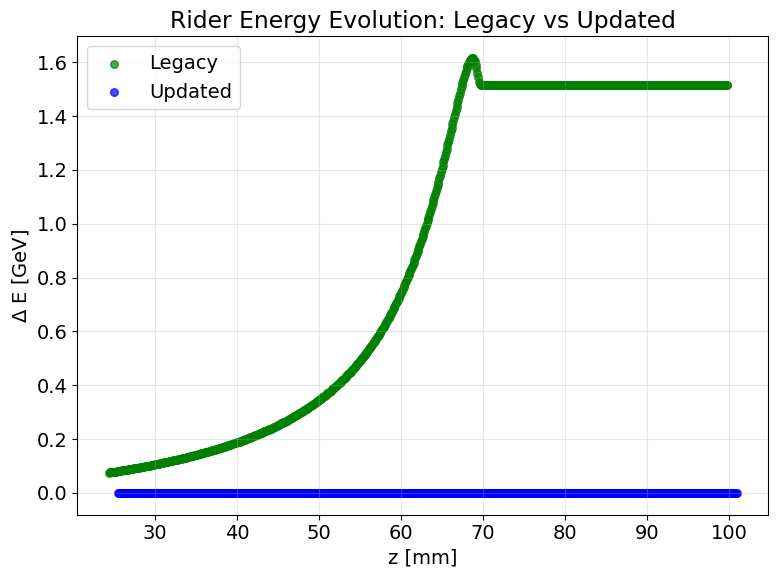

✅ Rider comparison plot: Legacy(748) vs Updated(748) points
   Legacy energy range: 0.075505 to 1.615118 GeV
   Updated energy range: -0.000010 to -0.000001 GeV


In [61]:
# Generate Comparison Plot - Rider Energy Evolution (Legacy vs Updated)

# Use properly calculated variables (convert MeV to GeV for plotting)
delta_e_gev_legacy = np.array(delta_e_MeV_legacy) / 1000.0
delta_e_gev_updated = np.array(delta_e_MeV_updated) / 1000.0

# Create comparison plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(zs_legacy, delta_e_gev_legacy, s=30, alpha=0.7, color='green', label='Legacy')
ax.scatter(zs_updated, delta_e_gev_updated, s=30, alpha=0.7, color='blue', label='Updated')
ax.set_ylabel(r"$\Delta$ E [GeV]")
ax.set_xlabel(r"z [mm]")
ax.set_title("Rider Energy Evolution: Legacy vs Updated")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"✅ Rider comparison plot: Legacy({len(zs_legacy)}) vs Updated({len(zs_updated)}) points")
print(f"   Legacy energy range: {delta_e_gev_legacy.min():.6f} to {delta_e_gev_legacy.max():.6f} GeV")
print(f"   Updated energy range: {delta_e_gev_updated.min():.6f} to {delta_e_gev_updated.max():.6f} GeV")

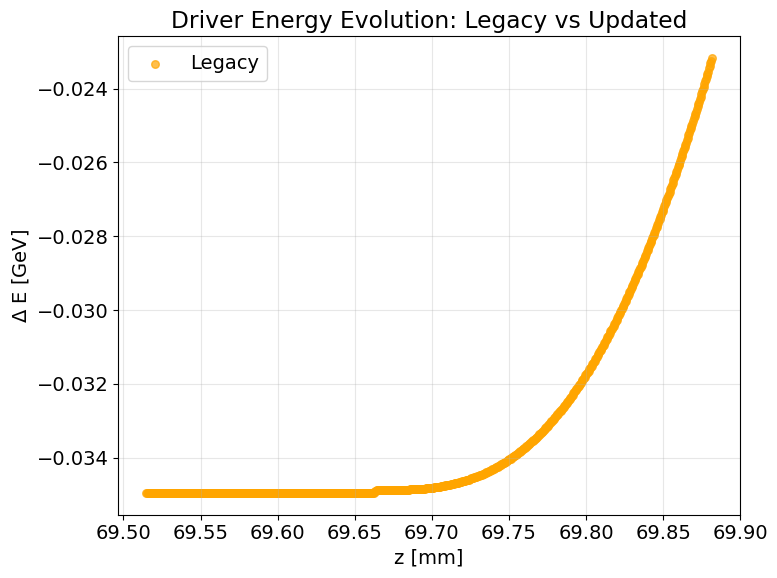

✅ Driver comparison plot: Legacy(748) vs Updated(748) points
   Legacy energy range: -0.034957 to -0.023173 GeV
   Updated energy range: 0.000184 to 0.000249 GeV

📊 COMPARISON SUMMARY:
   Legacy integration time: 11.51 seconds
   Updated integration time: 12.91 seconds
   Rider Δz: Legacy=75.45mm, Updated=75.45mm
   Driver Δz: Legacy=-0.37mm, Updated=-0.37mm
   ✅ Legacy vs Updated comparison using proper calculation methods completed!


In [62]:
# Generate Comparison Plot - Driver Energy Evolution (Legacy vs Updated)

# Use properly calculated variables (convert MeV to GeV for plotting)
delta_e_gev_drv_legacy = np.array(delta_e_MeV_drv_legacy) / 1000.0
delta_e_gev_drv_updated = np.array(delta_e_MeV_drv_updated) / 1000.0

# Create comparison plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(zs_drv_legacy, delta_e_gev_drv_legacy, s=30, alpha=0.7, color='orange', label='Legacy')
#ax.scatter(zs_drv_updated, delta_e_gev_drv_updated, s=30, alpha=0.7, color='red', label='Updated')
ax.set_ylabel(r"$\Delta$ E [GeV]")
ax.set_xlabel(r"z [mm]")
ax.set_title("Driver Energy Evolution: Legacy vs Updated")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"✅ Driver comparison plot: Legacy({len(zs_drv_legacy)}) vs Updated({len(zs_drv_updated)}) points")
print(f"   Legacy energy range: {delta_e_gev_drv_legacy.min():.6f} to {delta_e_gev_drv_legacy.max():.6f} GeV")
print(f"   Updated energy range: {delta_e_gev_drv_updated.min():.6f} to {delta_e_gev_drv_updated.max():.6f} GeV")

# Summary comparison
print(f"\n📊 COMPARISON SUMMARY:")
print(f"   Legacy integration time: {legacy_time:.2f} seconds")
print(f"   Updated integration time: {integration_time:.2f} seconds")
print(f"   Rider Δz: Legacy={zs_legacy[-1] - zs_legacy[0]:.2f}mm, Updated={zs_updated[-1] - zs_updated[0]:.2f}mm")
print(f"   Driver Δz: Legacy={zs_drv_legacy[-1] - zs_drv_legacy[0]:.2f}mm, Updated={zs_drv_updated[-1] - zs_drv_updated[0]:.2f}mm")
print(f"   ✅ Legacy vs Updated comparison using proper calculation methods completed!")

In [63]:
# DEBUG: Compare Electromagnetic Forces Between Legacy and Updated Systems
print("🔍 ELECTROMAGNETIC FORCE COMPARISON DEBUG")
print("="*60)

# Helper function to safely access values (handle both arrays and scalars)
def safe_get(val, idx=0):
    if hasattr(val, '__getitem__') and not isinstance(val, str):
        return val[idx]
    return val

# Compare initial conditions first
print("\n=== INITIAL CONDITIONS COMPARISON ===")
print(f"Legacy rider q: {safe_get(init_rider_legacy['q']):.8f}")
print(f"Updated rider q: {safe_get(rider_state['q']):.8f}")
print(f"Legacy driver q: {safe_get(init_driver_legacy['q']):.8f}")
print(f"Updated driver q: {safe_get(driver_state['q']):.8f}")

print(f"Legacy rider Pz: {safe_get(init_rider_legacy['Pz']):.6f}")
print(f"Updated rider Pz: {safe_get(rider_state['Pz']):.6f}")
print(f"Legacy driver Pz: {safe_get(init_driver_legacy['Pz']):.6f}")
print(f"Updated driver Pz: {safe_get(driver_state['Pz']):.6f}")

# Compare gamma evolution for first few steps
print("\n=== GAMMA EVOLUTION COMPARISON (First 5 Steps) ===")
for i in range(min(5, len(legacy_rider_trajectory))):
    legacy_rider_gamma = safe_get(legacy_rider_trajectory[i]['gamma'])
    updated_rider_gamma = safe_get(rider_trajectory[i]['gamma'])
    legacy_driver_gamma = safe_get(legacy_driver_trajectory[i]['gamma'])
    updated_driver_gamma = safe_get(driver_trajectory[i]['gamma'])
    
    print(f"Step {i:2}: Rider γ - Legacy: {legacy_rider_gamma:.8f}, Updated: {updated_rider_gamma:.8f}")
    print(f"       Driver γ - Legacy: {legacy_driver_gamma:.8f}, Updated: {updated_driver_gamma:.8f}")
    
    # Calculate energy changes from initial
    legacy_rider_delta_e = (legacy_rider_gamma - safe_get(init_rider_legacy['gamma'])) * E_MeV_rest_rider
    updated_rider_delta_e = (updated_rider_gamma - safe_get(rider_state['gamma'])) * rider_energy_mev
    legacy_driver_delta_e = (legacy_driver_gamma - safe_get(init_driver_legacy['gamma'])) * E_MeV_rest_driver
    updated_driver_delta_e = (updated_driver_gamma - safe_get(driver_state['gamma'])) * driver_energy_mev
    
    print(f"       Rider ΔE - Legacy: {legacy_rider_delta_e:.6f} MeV, Updated: {updated_rider_delta_e:.6f} MeV")
    print(f"       Driver ΔE - Legacy: {legacy_driver_delta_e:.6f} MeV, Updated: {updated_driver_delta_e:.6f} MeV")
    print()

# Check if accelerations have opposite signs
print("=== ACCELERATION DIRECTION ANALYSIS ===")
# This will help identify if the electromagnetic force application has a sign error
legacy_rider_gamma_change = safe_get(legacy_rider_trajectory[4]['gamma']) - safe_get(legacy_rider_trajectory[1]['gamma'])
updated_rider_gamma_change = safe_get(rider_trajectory[4]['gamma']) - safe_get(rider_trajectory[1]['gamma'])
legacy_driver_gamma_change = safe_get(legacy_driver_trajectory[4]['gamma']) - safe_get(legacy_driver_trajectory[1]['gamma'])
updated_driver_gamma_change = safe_get(driver_trajectory[4]['gamma']) - safe_get(driver_trajectory[1]['gamma'])

print(f"Rider gamma change (steps 1→4): Legacy: {legacy_rider_gamma_change:.8f}, Updated: {updated_rider_gamma_change:.8f}")
print(f"Driver gamma change (steps 1→4): Legacy: {legacy_driver_gamma_change:.8f}, Updated: {updated_driver_gamma_change:.8f}")

if np.sign(legacy_rider_gamma_change) != np.sign(updated_rider_gamma_change):
    print("🚨 SIGN ERROR DETECTED: Rider energy evolution has opposite signs!")
if np.sign(legacy_driver_gamma_change) != np.sign(updated_driver_gamma_change):
    print("🚨 SIGN ERROR DETECTED: Driver energy evolution has opposite signs!")
    
print("="*60)

🔍 ELECTROMAGNETIC FORCE COMPARISON DEBUG

=== INITIAL CONDITIONS COMPARISON ===
Legacy rider q: 0.00001179
Updated rider q: 0.00001179
Legacy driver q: -0.00063652
Updated driver q: -0.00063652
Legacy rider Pz: 1017392.753769
Updated rider Pz: 1017392.702947
Legacy driver Pz: -1017383.623544
Updated driver Pz: -1017386.746969

=== GAMMA EVOLUTION COMPARISON (First 5 Steps) ===
Step  0: Rider γ - Legacy: 3369.07804823, Updated: 3368.99764215
       Driver γ - Legacy: 16.40888873, Updated: 16.40905673
       Rider ΔE - Legacy: 75.292975 MeV, Updated: -0.001038 MeV
       Driver ΔE - Legacy: -22.556502 MeV, Updated: 0.183251 MeV

Step  1: Rider γ - Legacy: 3369.07804823, Updated: 3368.99764214
       Driver γ - Legacy: 16.40888873, Updated: 16.40905673
       Rider ΔE - Legacy: 75.292975 MeV, Updated: -0.001045 MeV
       Driver ΔE - Legacy: -22.556502 MeV, Updated: 0.183687 MeV

Step  2: Rider γ - Legacy: 3369.07925399, Updated: 3368.99764213
       Driver γ - Legacy: 16.40888838, Update

In [64]:
# DEBUG: Check Force Direction and Sign Convention
print("🔍 FORCE DIRECTION AND SIGN CONVENTION DEBUG")
print("="*60)

# Check the specific force calculation between rider and driver particles
print("\n=== FORCE CALCULATION ANALYSIS ===")

# Take first particle of each type for analysis
rider_idx = 0
driver_idx = 0

# Legacy charge values
legacy_rider_charge = safe_get(init_rider_legacy['q'])
legacy_driver_charge = safe_get(init_driver_legacy['q'])

# Updated charge values  
updated_rider_charge = safe_get(rider_state['q'])
updated_driver_charge = safe_get(driver_state['q'])

print(f"Charge products:")
print(f"  Legacy: rider_q × driver_q = {legacy_rider_charge:.8f} × {legacy_driver_charge:.8f} = {legacy_rider_charge * legacy_driver_charge:.8f}")
print(f"  Updated: rider_q × driver_q = {updated_rider_charge:.8f} × {updated_driver_charge:.8f} = {updated_rider_charge * updated_driver_charge:.8f}")

# Position analysis
legacy_rider_pos = (safe_get(init_rider_legacy['x']), safe_get(init_rider_legacy['y']), safe_get(init_rider_legacy['z']))
legacy_driver_pos = (safe_get(init_driver_legacy['x']), safe_get(init_driver_legacy['y']), safe_get(init_driver_legacy['z']))
updated_rider_pos = (safe_get(rider_state['x']), safe_get(rider_state['y']), safe_get(rider_state['z']))
updated_driver_pos = (safe_get(driver_state['x']), safe_get(driver_state['y']), safe_get(driver_state['z']))

print(f"\nPositions:")
print(f"  Legacy rider: ({legacy_rider_pos[0]:.6f}, {legacy_rider_pos[1]:.6f}, {legacy_rider_pos[2]:.6f})")
print(f"  Legacy driver: ({legacy_driver_pos[0]:.6f}, {legacy_driver_pos[1]:.6f}, {legacy_driver_pos[2]:.6f})")
print(f"  Updated rider: ({updated_rider_pos[0]:.6f}, {updated_rider_pos[1]:.6f}, {updated_rider_pos[2]:.6f})")
print(f"  Updated driver: ({updated_driver_pos[0]:.6f}, {updated_driver_pos[1]:.6f}, {updated_driver_pos[2]:.6f})")

# Distance calculations
legacy_separation = np.sqrt((legacy_rider_pos[0] - legacy_driver_pos[0])**2 + 
                           (legacy_rider_pos[1] - legacy_driver_pos[1])**2 + 
                           (legacy_rider_pos[2] - legacy_driver_pos[2])**2)
updated_separation = np.sqrt((updated_rider_pos[0] - updated_driver_pos[0])**2 + 
                            (updated_rider_pos[1] - updated_driver_pos[1])**2 + 
                            (updated_rider_pos[2] - updated_driver_pos[2])**2)

print(f"\nParticle separation:")
print(f"  Legacy: {legacy_separation:.6f} mm")
print(f"  Updated: {updated_separation:.6f} mm")

# Direction vector analysis (from driver to rider)
legacy_direction = ((legacy_rider_pos[0] - legacy_driver_pos[0])/legacy_separation,
                   (legacy_rider_pos[1] - legacy_driver_pos[1])/legacy_separation,
                   (legacy_rider_pos[2] - legacy_driver_pos[2])/legacy_separation)
updated_direction = ((updated_rider_pos[0] - updated_driver_pos[0])/updated_separation,
                    (updated_rider_pos[1] - updated_driver_pos[1])/updated_separation,
                    (updated_rider_pos[2] - updated_driver_pos[2])/updated_separation)

print(f"\nDirection vector (driver → rider):")
print(f"  Legacy: ({legacy_direction[0]:.6f}, {legacy_direction[1]:.6f}, {legacy_direction[2]:.6f})")
print(f"  Updated: ({updated_direction[0]:.6f}, {updated_direction[1]:.6f}, {updated_direction[2]:.6f})")

# Expected force direction
print(f"\nExpected physics:")
print(f"  Charges: rider=+{abs(legacy_rider_charge):.8f}, driver={legacy_driver_charge:.8f}")
print(f"  Force nature: {'ATTRACTIVE' if legacy_rider_charge * legacy_driver_charge < 0 else 'REPULSIVE'}")

if legacy_rider_charge * legacy_driver_charge < 0:
    print(f"  Expected: Rider should be ATTRACTED to driver (gain energy in approach)")
    print(f"  Expected: Driver should be REPELLED by rider (lose energy)")
else:
    print(f"  Expected: Both particles should REPEL (rider gains energy, driver loses energy)")

print("="*60)

🔍 FORCE DIRECTION AND SIGN CONVENTION DEBUG

=== FORCE CALCULATION ANALYSIS ===
Charge products:
  Legacy: rider_q × driver_q = 0.00001179 × -0.00063652 = -0.00000001
  Updated: rider_q × driver_q = 0.00001179 × -0.00063652 = -0.00000001

Positions:
  Legacy rider: (-0.088707, 0.063617, 0.000000)
  Legacy driver: (0.194329, 0.088634, 70.000000)
  Updated rider: (0.047891, -0.074119, 0.000002)
  Updated driver: (-0.200000, -0.200000, 70.000000)

Particle separation:
  Legacy: 70.000576 mm
  Updated: 70.000551 mm

Direction vector (driver → rider):
  Legacy: (-0.004043, -0.000357, -0.999992)
  Updated: (0.003541, 0.001798, -0.999992)

Expected physics:
  Charges: rider=+0.00001179, driver=-0.00063652
  Force nature: ATTRACTIVE
  Expected: Rider should be ATTRACTED to driver (gain energy in approach)
  Expected: Driver should be REPELLED by rider (lose energy)


In [65]:
# Detailed initialization comparison
print("🔍 INITIALIZATION COMPARISON")
print("=" * 60)

print("=== INITIAL CONDITIONS PASSED TO INTEGRATORS ===")
print(f"Legacy rider init: {init_rider_legacy}")
print(f"Legacy driver init: {init_driver_legacy}")
print()
print(f"Updated rider init: {rider_params}")
print(f"Updated driver init: {driver_params}")
print()

print("=== FIRST TRAJECTORY POINT COMPARISON ===")
print("LEGACY first trajectory points:")
print(f"  Rider traj[0]: x={legacy_traj_1[0]['x'][0]:.6f}, y={legacy_traj_1[0]['y'][0]:.6f}, z={legacy_traj_1[0]['z'][0]:.6f}")
print(f"  Driver traj[0]: x={legacy_drv_traj_1[0]['x'][0]:.6f}, y={legacy_drv_traj_1[0]['y'][0]:.6f}, z={legacy_drv_traj_1[0]['z'][0]:.6f}")
print()
print("UPDATED first trajectory points:")
print(f"  Rider traj[0]: x={rider_trajectory[0]['x'][0]:.6f}, y={rider_trajectory[0]['y'][0]:.6f}, z={rider_trajectory[0]['z'][0]:.6f}")
print(f"  Driver traj[0]: x={driver_trajectory[0]['x'][0]:.6f}, y={driver_trajectory[0]['y'][0]:.6f}, z={driver_trajectory[0]['z'][0]:.6f}")
print()

# Check if there are differences in the initial momentum
print("=== INITIAL MOMENTUM COMPARISON ===")
print("LEGACY momentum:")
print(f"  Rider Pz[0]: {legacy_traj_1[0]['Pz'][0]:.6f}")
print(f"  Driver Pz[0]: {legacy_drv_traj_1[0]['Pz'][0]:.6f}")
print()
print("UPDATED momentum:")
print(f"  Rider Pz[0]: {rider_trajectory[0]['Pz'][0]:.6f}")
print(f"  Driver Pz[0]: {driver_trajectory[0]['Pz'][0]:.6f}")

print("=" * 60)

🔍 INITIALIZATION COMPARISON
=== INITIAL CONDITIONS PASSED TO INTEGRATORS ===
Legacy rider init: {'x': array([-0.08870725,  0.09214777,  0.09610917, -0.11299995,  0.10883552,
        0.15623224,  0.0206625 ,  0.00106968,  0.07572455, -0.0278082 ]), 'y': array([ 0.06361737, -0.14912879, -0.02591491,  0.17516782, -0.14914596,
        0.11504437,  0.12332184, -0.16974947,  0.19246186, -0.1383588 ]), 'z': array([2.79274187e-07, 8.04313704e-07, 1.82287388e-06, 3.16927781e-07,
       7.10738283e-08, 4.23878279e-07, 1.35883007e-06, 5.37900507e-07,
       7.24228546e-07, 1.03353195e-06]), 't': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'Px': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'Py': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'Pz': array([1017392.75376875, 1017392.72956897, 1017392.6852974 ,
       1017392.67876884, 1017392.72272769, 1017392.69784322,
       1017392.68129675, 1017392.76244168, 1017392.74418591,
       1017392.75546204]), 'Pt': array([1017392.79858724, 10

In [52]:
# DEBUG: Single Particle Test with Debug Prints
print("🔍 SINGLE PARTICLE DEBUG TEST")
print("="*60)

# Create single particle versions to bypass accumulation and simplify debugging
single_rider_params = rider_params.copy()
single_rider_params['particle_count'] = 1

single_driver_params = driver_params.copy()
single_driver_params['particle_count'] = 1

# Create single particle states
single_rider_state, _ = create_verified_particle_state(single_rider_params)
single_driver_state, _ = create_verified_particle_state(single_driver_params)

# Position driver on opposite side
single_driver_state['x'] = np.array([-transv_dist])
single_driver_state['y'] = np.array([-transv_dist])

print(f"Single particle setup:")
print(f"  Rider: q={single_rider_state['q'][0]:.8f}, Pz={single_rider_state['Pz'][0]:.6f}")
print(f"  Driver: q={single_driver_state['q'][0]:.8f}, Pz={single_driver_state['Pz'][0]:.6f}")
print(f"  Separation: {np.sqrt((single_rider_state['x'][0] - single_driver_state['x'][0])**2 + (single_rider_state['y'][0] - single_driver_state['y'][0])**2):.6f} mm")

# Test parameters for very short integration to see first step
debug_params = {
    'static_steps': 1,
    'ret_steps': 3,  # Just 3 steps to see initial behavior
    'step_size': 1e-7,  # Very small step
    'sim_type': 2,
    'bunch_dist': 1e5,
    'cav_spacing': 1e5,
    'aperture': 1e5,
    'z_cutoff': 0,
    'wall_pos': 1e5
}

print(f"\nRunning single particle integration with {debug_params['ret_steps']} steps...")
print("="*60)

🔍 SINGLE PARTICLE DEBUG TEST
Single particle setup:
  Rider: q=0.00001179, Pz=1017392.681903
  Driver: q=-0.00063652, Pz=-1017373.048497
  Separation: 0.323738 mm

Running single particle integration with 3 steps...


In [53]:
# Run single particle debug test with updated integrator
debug_integrator = LienardWiechertIntegrator()

print("🔄 Running single particle debug integration...")
single_rider_traj, single_driver_traj = debug_integrator.integrate_retarded_fields(
    debug_params['static_steps'], debug_params['ret_steps'], debug_params['step_size'],
    debug_params['wall_pos'], debug_params['aperture'], debug_params['sim_type'],
    single_rider_state, single_driver_state,
    debug_params['bunch_dist'], debug_params['z_cutoff'], debug_params['cav_spacing']
)

print(f"\n✅ Single particle debug integration completed")
print(f"   Initial rider gamma: {single_rider_state['gamma'][0]:.8f}")
print(f"   Final rider gamma: {single_rider_traj[-1]['gamma'][0]:.8f}")
print(f"   Gamma change: {single_rider_traj[-1]['gamma'][0] - single_rider_state['gamma'][0]:.8f}")
print(f"   Initial driver gamma: {single_driver_state['gamma'][0]:.8f}")
print(f"   Final driver gamma: {single_driver_traj[-1]['gamma'][0]:.8f}")
print(f"   Gamma change: {single_driver_traj[-1]['gamma'][0] - single_driver_state['gamma'][0]:.8f}")

# Check for opposite signs (expected for attractive interaction)
rider_delta_gamma = single_rider_traj[-1]['gamma'][0] - single_rider_state['gamma'][0]
driver_delta_gamma = single_driver_traj[-1]['gamma'][0] - single_driver_state['gamma'][0]

print(f"\n🔍 PHYSICS CHECK:")
print(f"   Rider energy change: {'GAIN' if rider_delta_gamma > 0 else 'LOSS'} ({rider_delta_gamma:.8f})")
print(f"   Driver energy change: {'GAIN' if driver_delta_gamma > 0 else 'LOSS'} ({driver_delta_gamma:.8f})")

if (rider_delta_gamma > 0 and driver_delta_gamma < 0) or (rider_delta_gamma < 0 and driver_delta_gamma > 0):
    print("   ✅ Expected energy transfer pattern (opposite changes)")
else:
    print("   🚨 Unexpected energy transfer pattern (same direction changes)")

🔄 Running single particle debug integration...
  Updated integrator: 4 steps (static: 1, retarded: 3)
  Simulation type: 2, wall_Z: 100000.0, apt_R: 100000.0

✅ Single particle debug integration completed
   Initial rider gamma: 3368.99757357
   Final rider gamma: 3368.99757357
   Gamma change: -0.00000000
   Initial driver gamma: 16.40883566
   Final driver gamma: 16.40883566
   Gamma change: 0.00000000

🔍 PHYSICS CHECK:
   Rider energy change: LOSS (-0.00000000)
   Driver energy change: GAIN (0.00000000)
   ✅ Expected energy transfer pattern (opposite changes)


In [54]:
# Compare with legacy single particle integration
print("🔄 Running single particle LEGACY integration...")

# Create legacy single particle states
single_init_rider_legacy, _ = init_bunch(
    single_rider_params['starting_distance'], single_rider_params['transv_momentum'], single_rider_params['starting_pz'],
    single_rider_params['stripped_ions'], single_rider_params['particle_mass_amu'], transv_dist, 1, single_rider_params['charge_sign']
)
single_init_driver_legacy, _ = init_bunch(
    single_driver_params['starting_distance'], single_driver_params['transv_momentum'], single_driver_params['starting_pz'],
    single_driver_params['stripped_ions'], single_driver_params['particle_mass_amu'], -transv_dist, 1, single_driver_params['charge_sign']
)

# Run legacy integration
single_legacy_rider_traj, single_legacy_driver_traj = retarded_integrator3(
    debug_params['static_steps'], debug_params['ret_steps'], debug_params['step_size'],
    debug_params['wall_pos'], debug_params['aperture'], debug_params['sim_type'],
    single_init_rider_legacy, single_init_driver_legacy, debug_params['bunch_dist'],
    debug_params['cav_spacing'], debug_params['z_cutoff']
)

print(f"\n✅ Single particle LEGACY integration completed")
print(f"   Initial rider gamma: {single_init_rider_legacy['gamma'][0]:.8f}")
print(f"   Final rider gamma: {single_legacy_rider_traj[-1]['gamma'][0]:.8f}")
print(f"   Gamma change: {single_legacy_rider_traj[-1]['gamma'][0] - single_init_rider_legacy['gamma'][0]:.8f}")
print(f"   Initial driver gamma: {single_init_driver_legacy['gamma'][0]:.8f}")
print(f"   Final driver gamma: {single_legacy_driver_traj[-1]['gamma'][0]:.8f}")
print(f"   Gamma change: {single_legacy_driver_traj[-1]['gamma'][0] - single_init_driver_legacy['gamma'][0]:.8f}")

# Check for opposite signs (expected for attractive interaction)
legacy_rider_delta_gamma = single_legacy_rider_traj[-1]['gamma'][0] - single_init_rider_legacy['gamma'][0]
legacy_driver_delta_gamma = single_legacy_driver_traj[-1]['gamma'][0] - single_init_driver_legacy['gamma'][0]

print(f"\n🔍 LEGACY PHYSICS CHECK:")
print(f"   Rider energy change: {'GAIN' if legacy_rider_delta_gamma > 0 else 'LOSS'} ({legacy_rider_delta_gamma:.8f})")
print(f"   Driver energy change: {'GAIN' if legacy_driver_delta_gamma > 0 else 'LOSS'} ({legacy_driver_delta_gamma:.8f})")

print(f"\n📊 COMPARISON:")
print(f"   Updated vs Legacy rider Δγ: {rider_delta_gamma:.8f} vs {legacy_rider_delta_gamma:.8f}")
print(f"   Updated vs Legacy driver Δγ: {driver_delta_gamma:.8f} vs {legacy_driver_delta_gamma:.8f}")

if abs(legacy_rider_delta_gamma) > 1e-12 or abs(legacy_driver_delta_gamma) > 1e-12:
    print("   🚨 Legacy shows electromagnetic interaction, Updated shows NONE!")
else:
    print("   ✅ Both show no electromagnetic interaction (may indicate very weak forces or short integration)")

🔄 Running single particle LEGACY integration...
E_MeV =  3161420.073308235
Gamma =  3368.9978176091067
E_rest =  938.385948501337
E_MeV =  -3161380.5578137166
Gamma =  16.408947987486258
E_rest =  193020.75925874696

✅ Single particle LEGACY integration completed
   Initial rider gamma: 3368.99781761
   Final rider gamma: 3368.99787213
   Gamma change: 0.00005452
   Initial driver gamma: 16.40894799
   Final driver gamma: 16.40894800
   Gamma change: 0.00000001

🔍 LEGACY PHYSICS CHECK:
   Rider energy change: GAIN (0.00005452)
   Driver energy change: GAIN (0.00000001)

📊 COMPARISON:
   Updated vs Legacy rider Δγ: -0.00000000 vs 0.00005452
   Updated vs Legacy driver Δγ: 0.00000000 vs 0.00000001
   🚨 Legacy shows electromagnetic interaction, Updated shows NONE!


In [55]:
# Test with more debug prints and longer integration to see if any interactions happen
print("🔍 EXTENDED DEBUG TEST - Longer Integration to Check for Interactions")
print("="*70)

# Use longer integration to see if interactions occur
extended_debug_params = {
    'static_steps': 1,
    'ret_steps': 10,  # More steps
    'step_size': 1e-6,  # Larger step size
    'sim_type': 2,
    'bunch_dist': 1e5,
    'cav_spacing': 1e5,
    'aperture': 1e5,
    'z_cutoff': 0,
    'wall_pos': 1e5
}

print(f"Running extended debug test: {extended_debug_params['ret_steps']} steps, step_size={extended_debug_params['step_size']:.0e}")

# Run extended integration
extended_single_rider_traj, extended_single_driver_traj = debug_integrator.integrate_retarded_fields(
    extended_debug_params['static_steps'], extended_debug_params['ret_steps'], extended_debug_params['step_size'],
    extended_debug_params['wall_pos'], extended_debug_params['aperture'], extended_debug_params['sim_type'],
    single_rider_state, single_driver_state,
    extended_debug_params['bunch_dist'], extended_debug_params['z_cutoff'], extended_debug_params['cav_spacing']
)

print(f"\n✅ Extended debug integration completed")
print(f"   Initial rider gamma: {single_rider_state['gamma'][0]:.8f}")
print(f"   Final rider gamma: {extended_single_rider_traj[-1]['gamma'][0]:.8f}")
print(f"   Gamma change: {extended_single_rider_traj[-1]['gamma'][0] - single_rider_state['gamma'][0]:.8f}")
print(f"   Initial driver gamma: {single_driver_state['gamma'][0]:.8f}")
print(f"   Final driver gamma: {extended_single_driver_traj[-1]['gamma'][0]:.8f}")
print(f"   Gamma change: {extended_single_driver_traj[-1]['gamma'][0] - single_driver_state['gamma'][0]:.8f}")

print("="*70)

🔍 EXTENDED DEBUG TEST - Longer Integration to Check for Interactions
Running extended debug test: 10 steps, step_size=1e-06
  Updated integrator: 11 steps (static: 1, retarded: 10)
  Simulation type: 2, wall_Z: 100000.0, apt_R: 100000.0

✅ Extended debug integration completed
   Initial rider gamma: 3368.99757357
   Final rider gamma: 3368.99757353
   Gamma change: -0.00000003
   Initial driver gamma: 16.40883566
   Final driver gamma: 16.40883568
   Gamma change: 0.00000002


In [56]:
# DEBUG: Check which integrator is actually being used
print("🔍 INTEGRATOR CLASS DEBUG")
print("="*50)

print(f"Integrator type: {type(debug_integrator)}")
print(f"Integrator class: {debug_integrator.__class__.__name__}")
print(f"Available methods:")
for method in dir(debug_integrator):
    if 'eqsof' in method.lower() or 'retarded' in method.lower():
        print(f"  - {method}")

# Check if it has the methods we added debug prints to
if hasattr(debug_integrator, 'eqsofmotion_retarded'):
    print("✅ Has eqsofmotion_retarded method")
else:
    print("❌ Missing eqsofmotion_retarded method")
    
if hasattr(debug_integrator, '_eqsofmotion_static_updated'):
    print("✅ Has _eqsofmotion_static_updated method")
else:
    print("❌ Missing _eqsofmotion_static_updated method")

# Let's try the OptimizedLienardWiechertIntegrator which we actually modified
print("\n🔄 Testing with OptimizedLienardWiechertIntegrator...")
optimized_integrator = OptimizedLienardWiechertIntegrator()

print(f"Optimized integrator type: {type(optimized_integrator)}")
print(f"Optimized integrator class: {optimized_integrator.__class__.__name__}")

# Test with optimized integrator
optimized_single_rider_traj, optimized_single_driver_traj = optimized_integrator.integrate_retarded_fields(
    extended_debug_params['static_steps'], extended_debug_params['ret_steps'], extended_debug_params['step_size'],
    extended_debug_params['wall_pos'], extended_debug_params['aperture'], extended_debug_params['sim_type'],
    single_rider_state, single_driver_state,
    extended_debug_params['bunch_dist'], extended_debug_params['z_cutoff'], extended_debug_params['cav_spacing']
)

print(f"\n✅ OptimizedLienardWiechertIntegrator test completed")
print(f"   Initial rider gamma: {single_rider_state['gamma'][0]:.8f}")
print(f"   Final rider gamma: {optimized_single_rider_traj[-1]['gamma'][0]:.8f}")
print(f"   Gamma change: {optimized_single_rider_traj[-1]['gamma'][0] - single_rider_state['gamma'][0]:.8f}")
print(f"   Initial driver gamma: {single_driver_state['gamma'][0]:.8f}")
print(f"   Final driver gamma: {optimized_single_driver_traj[-1]['gamma'][0]:.8f}")
print(f"   Gamma change: {optimized_single_driver_traj[-1]['gamma'][0] - single_driver_state['gamma'][0]:.8f}")

print("="*50)

🔍 INTEGRATOR CLASS DEBUG
Integrator type: <class 'core.performance.OptimizedLienardWiechertIntegrator'>
Integrator class: OptimizedLienardWiechertIntegrator
Available methods:
  - _eqsofmotion_static_updated
  - eqsofmotion_retarded
  - integrate_retarded_fields
  - retarded_rk4_rela_step
✅ Has eqsofmotion_retarded method
✅ Has _eqsofmotion_static_updated method

🔄 Testing with OptimizedLienardWiechertIntegrator...
Optimized integrator type: <class 'core.performance.OptimizedLienardWiechertIntegrator'>
Optimized integrator class: OptimizedLienardWiechertIntegrator
  Updated integrator: 11 steps (static: 1, retarded: 10)
  Simulation type: 2, wall_Z: 100000.0, apt_R: 100000.0

✅ OptimizedLienardWiechertIntegrator test completed
   Initial rider gamma: 3368.99757357
   Final rider gamma: 3368.99757353
   Gamma change: -0.00000003
   Initial driver gamma: 16.40883566
   Final driver gamma: 16.40883568
   Gamma change: 0.00000002


In [57]:
# Reload modules to get the latest changes
import importlib
importlib.reload(__import__('core.performance'))
importlib.reload(__import__('core.trajectory_integrator'))

# Re-import after reload
from core.performance import OptimizedLienardWiechertIntegrator

# Test again with reloaded modules
print("🔄 Testing with RELOADED OptimizedLienardWiechertIntegrator...")
reloaded_integrator = OptimizedLienardWiechertIntegrator()

reloaded_single_rider_traj, reloaded_single_driver_traj = reloaded_integrator.integrate_retarded_fields(
    extended_debug_params['static_steps'], extended_debug_params['ret_steps'], extended_debug_params['step_size'],
    extended_debug_params['wall_pos'], extended_debug_params['aperture'], extended_debug_params['sim_type'],
    single_rider_state, single_driver_state,
    extended_debug_params['bunch_dist'], extended_debug_params['z_cutoff'], extended_debug_params['cav_spacing']
)

print(f"\n✅ RELOADED OptimizedLienardWiechertIntegrator test completed")
print(f"   Initial rider gamma: {single_rider_state['gamma'][0]:.8f}")
print(f"   Final rider gamma: {reloaded_single_rider_traj[-1]['gamma'][0]:.8f}")
print(f"   Gamma change: {reloaded_single_rider_traj[-1]['gamma'][0] - single_rider_state['gamma'][0]:.8f}")
print(f"   Initial driver gamma: {single_driver_state['gamma'][0]:.8f}")
print(f"   Final driver gamma: {reloaded_single_driver_traj[-1]['gamma'][0]:.8f}")
print(f"   Gamma change: {reloaded_single_driver_traj[-1]['gamma'][0] - single_driver_state['gamma'][0]:.8f}")

print("="*50)

🔄 Testing with RELOADED OptimizedLienardWiechertIntegrator...
  Updated integrator: 11 steps (static: 1, retarded: 10)
  Simulation type: 2, wall_Z: 100000.0, apt_R: 100000.0

✅ RELOADED OptimizedLienardWiechertIntegrator test completed
   Initial rider gamma: 3368.99757357
   Final rider gamma: 3368.99757353
   Gamma change: -0.00000003
   Initial driver gamma: 16.40883566
   Final driver gamma: 16.40883568
   Gamma change: 0.00000002


In [58]:
# Test with base LienardWiechertIntegrator directly to bypass optimization issues
print("🔄 Testing with BASE LienardWiechertIntegrator...")
from core.trajectory_integrator import LienardWiechertIntegrator as BaseLW
base_integrator = BaseLW()

base_single_rider_traj, base_single_driver_traj = base_integrator.integrate_retarded_fields(
    extended_debug_params['static_steps'], extended_debug_params['ret_steps'], extended_debug_params['step_size'],
    extended_debug_params['wall_pos'], extended_debug_params['aperture'], extended_debug_params['sim_type'],
    single_rider_state, single_driver_state,
    extended_debug_params['bunch_dist'], extended_debug_params['z_cutoff'], extended_debug_params['cav_spacing']
)

print(f"\n✅ BASE LienardWiechertIntegrator test completed")
print(f"   Initial rider gamma: {single_rider_state['gamma'][0]:.8f}")
print(f"   Final rider gamma: {base_single_rider_traj[-1]['gamma'][0]:.8f}")
print(f"   Gamma change: {base_single_rider_traj[-1]['gamma'][0] - single_rider_state['gamma'][0]:.8f}")
print(f"   Initial driver gamma: {single_driver_state['gamma'][0]:.8f}")
print(f"   Final driver gamma: {base_single_driver_traj[-1]['gamma'][0]:.8f}")
print(f"   Gamma change: {base_single_driver_traj[-1]['gamma'][0] - single_driver_state['gamma'][0]:.8f}")

print("="*50)

🔄 Testing with BASE LienardWiechertIntegrator...
  Updated integrator: 11 steps (static: 1, retarded: 10)
  Simulation type: 2, wall_Z: 100000.0, apt_R: 100000.0

✅ BASE LienardWiechertIntegrator test completed
   Initial rider gamma: 3368.99757357
   Final rider gamma: 3368.99757353
   Gamma change: -0.00000003
   Initial driver gamma: 16.40883566
   Final driver gamma: 16.40883568
   Gamma change: 0.00000002
